In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import ast
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Google Sheets URLs
TRAIN_URL = "https://docs.google.com/spreadsheets/d/1MZh2bF-HkR_fihYbpfJKg4KsqIJcj0KNbbIKajRw0no/export?format=csv"
TEST_URL = "https://docs.google.com/spreadsheets/d/1sbDIln-QrrHT2Aw6ESQdzvhRfzk2iMo3OJ6dNm1xR3U/export?format=csv"

In [3]:
class POSTagger:
    def __init__(self):
        self.emission_probs = defaultdict(lambda: defaultdict(float))
        self.transition_probs = defaultdict(lambda: defaultdict(float))
        self.initial_probs = defaultdict(float)
        self.tags = set()
        self.words = set()

    def load_data(self, url):
        """Load and parse the data from Google Sheets URL."""
        df = pd.read_csv(url, header=None)
        sentences = []

        for row in df[0]:  # Using column index 0 since there's no header
            try:
                # Clean and parse the string representation
                row = row.strip()
                if row.startswith("[") and row.endswith("]"):
                    # Parse the word-tag pairs
                    pairs = ast.literal_eval(row)
                    # Convert to (word, tag) format
                    sentence = [(pair[0], pair[1]) for pair in pairs]
                    sentences.append(sentence)
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing row: {row}")
                continue

        return sentences

    def explore_data(self, data, name="Dataset"):
        """Explore the structure of the dataset."""
        print(f"\nExploring {name}:")
        print(f"Number of sentences: {len(data)}")
        print(f"First sentence: {data[0]}")
        print(f"Unique tags in first sentence: {set(tag for _, tag in data[0])}")
        print(f"Unique words in first sentence: {set(word for word, _ in data[0])}")

    def train(self, training_data):
        """Estimate HMM parameters from training data."""
        # Collect counts
        tag_counts = Counter()
        tag_transition_counts = defaultdict(Counter)
        word_tag_counts = defaultdict(Counter)
        initial_tag_counts = Counter()

        for sentence in training_data:
            if not sentence:
                continue

            # Count initial tags
            initial_tag_counts[sentence[0][1]] += 1

            # Count tags and emissions
            for word, tag in sentence:
                self.words.add(word)
                self.tags.add(tag)
                tag_counts[tag] += 1
                word_tag_counts[tag][word] += 1

            # Count transitions
            for i in range(len(sentence)-1):
                current_tag = sentence[i][1]
                next_tag = sentence[i+1][1]
                tag_transition_counts[current_tag][next_tag] += 1

        # Calculate probabilities
        total_sentences = sum(initial_tag_counts.values())

        # Initial probabilities
        for tag in initial_tag_counts:
            self.initial_probs[tag] = initial_tag_counts[tag] / total_sentences

        # Emission probabilities
        for tag in self.tags:
            total_tag = sum(word_tag_counts[tag].values())
            for word in word_tag_counts[tag]:
                self.emission_probs[tag][word] = word_tag_counts[tag][word] / total_tag

        # Transition probabilities
        for tag1 in self.tags:
            total_transitions = sum(tag_transition_counts[tag1].values())
            if total_transitions > 0:
                for tag2 in self.tags:
                    self.transition_probs[tag1][tag2] = tag_transition_counts[tag1][tag2] / total_transitions

    def viterbi(self, sentence):
        """Implement the Viterbi algorithm to find the most likely sequence of tags."""
        V = [{}]  # Viterbi matrix
        path = {}

        # Initialize base cases (t = 0)
        word = sentence[0][0]
        for tag in self.tags:
            # Handle unknown words with a small probability
            emission_prob = self.emission_probs[tag][word] if self.emission_probs[tag][word] > 0 else 1e-10
            V[0][tag] = np.log(self.initial_probs[tag] + 1e-10) + np.log(emission_prob)
            path[tag] = [tag]

        # Run Viterbi for t > 0
        for t in range(1, len(sentence)):
            V.append({})
            newpath = {}
            word = sentence[t][0]

            for curr_tag in self.tags:
                emission_prob = self.emission_probs[curr_tag][word] if self.emission_probs[curr_tag][word] > 0 else 1e-10

                (prob, state) = max(
                    (V[t-1][prev_tag] + np.log(self.transition_probs[prev_tag][curr_tag] + 1e-10) + np.log(emission_prob),
                     prev_tag)
                    for prev_tag in self.tags
                )

                V[t][curr_tag] = prob
                newpath[curr_tag] = path[state] + [curr_tag]

            path = newpath

        # Find the best path
        (prob, state) = max((V[len(sentence) - 1][tag], tag) for tag in self.tags)
        return path[state]

    def predict(self, test_data):
        """Predict tags for test data."""
        predictions = []
        true_tags = []

        for sentence in test_data:
            if not sentence:
                continue

            words = [(word, '') for word, tag in sentence]
            predicted_tags = self.viterbi(words)
            actual_tags = [tag for _, tag in sentence]

            predictions.extend(predicted_tags)
            true_tags.extend(actual_tags)

        return predictions, true_tags

    def evaluate(self, predictions, true_tags):
        """Evaluate model performance."""
        accuracy = accuracy_score(true_tags, predictions)
        conf_matrix = confusion_matrix(true_tags, predictions, labels=sorted(list(self.tags)))

        return accuracy, conf_matrix

In [4]:
def plot_confusion_matrix(conf_matrix, tags):
    """Plot confusion matrix using seaborn."""
    plt.figure(figsize=(15, 15))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=sorted(list(tags)),
                yticklabels=sorted(list(tags)))
    plt.title('Confusion Matrix')
    plt.ylabel('True Tags')
    plt.xlabel('Predicted Tags')
    plt.tight_layout()
    plt.show()

Loading training data...

Exploring Training Data:
Number of sentences: 52499
First sentence: [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM', 'NOUN')]
Unique tags in first sentence: {'NOUN', 'NUM'}
Unique words in first sentence: {'03/01/2001', 'PM', '01:35'}
Loading test data...

Exploring Test Data:
Number of sentences: 65625
First sentence: [('DF', 'PROPN')]
Unique tags in first sentence: {'PROPN'}
Unique words in first sentence: {'DF'}
Training the model...
Number of unique tags: 21
Number of unique words: 58110
Making predictions...
Evaluating the model...

Model Performance:
Accuracy: 0.8961

Generating confusion matrix...


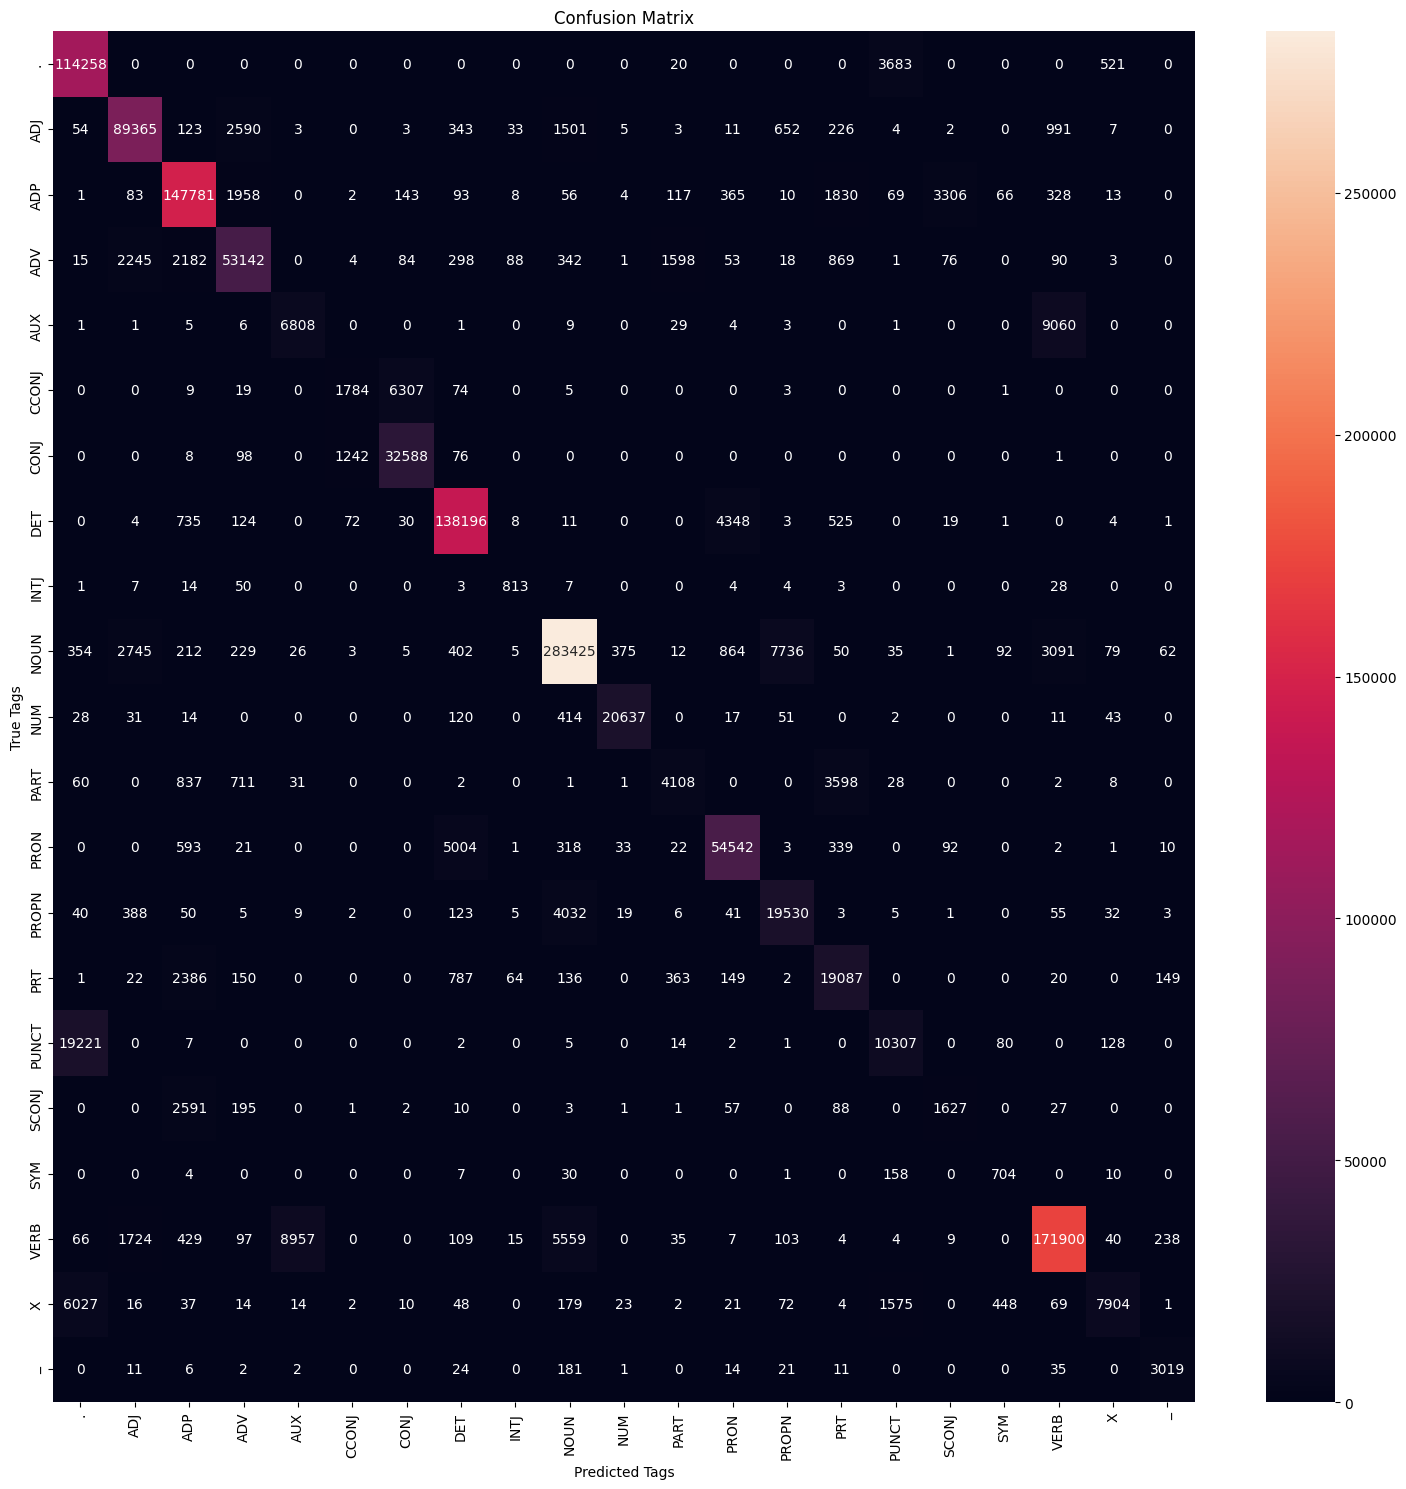

In [5]:
def main():
    # Initialize the POS tagger
    tagger = POSTagger()

    try:
        # Load and process data
        print("Loading training data...")
        training_data = tagger.load_data(TRAIN_URL)
        tagger.explore_data(training_data, "Training Data")

        print("Loading test data...")
        test_data = tagger.load_data(TEST_URL)
        tagger.explore_data(test_data, "Test Data")

        # Train the model
        print("Training the model...")
        tagger.train(training_data)
        print(f"Number of unique tags: {len(tagger.tags)}")
        print(f"Number of unique words: {len(tagger.words)}")

        # Make predictions
        print("Making predictions...")
        predictions, true_tags = tagger.predict(test_data)

        # Evaluate the model
        print("Evaluating the model...")
        accuracy, conf_matrix = tagger.evaluate(predictions, true_tags)

        print(f"\nModel Performance:")
        print(f"Accuracy: {accuracy:.4f}")

        # Plot confusion matrix
        print("\nGenerating confusion matrix...")
        plot_confusion_matrix(conf_matrix, tagger.tags)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()